## Task3: Customer Segmentation / Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('/kaggle/input/zeotap-dataset/Customers.csv')
transactions = pd.read_csv('/kaggle/input/zeotap-dataset/Transactions.csv')
products = pd.read_csv('/kaggle/input/zeotap-dataset/Products.csv')

In [2]:
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Calculate Tenure (days from signup to last transaction)
max_transaction_date = transactions['TransactionDate'].max()
customers['Tenure'] = (max_transaction_date - customers['SignupDate']).dt.days

# One-hot encode Region
customers = pd.get_dummies(customers, columns=['Region'], prefix='Region')

# Drop unnecessary columns
customers = customers.drop(['CustomerName', 'SignupDate'], axis=1)

In [3]:
# Merge transactions with products to get category
transactions = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID', how='left')

# Aggregate transaction data per customer
customer_agg = transactions.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (max_transaction_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum'),
    AvgQuantity=('Quantity', 'mean')
).reset_index()

# Calculate category-wise spending
category_spending = pd.pivot_table(
    transactions,
    index='CustomerID',
    columns='Category',
    values='TotalValue',
    aggfunc='sum',
    fill_value=0
).add_prefix('Category_')

# Merge aggregated data
customer_features = pd.merge(customer_agg, category_spending, on='CustomerID', how='left')

In [4]:
# Merge customer features with profile data
data = pd.merge(customers, customer_features, on='CustomerID', how='left').fillna(0)

# Drop CustomerID for clustering
features = data.drop('CustomerID', axis=1)

In [5]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [6]:
# Calculate clustering metrics for k=2 to k=10
db_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Find optimal k (lowest DB Index)
optimal_k = k_values[np.argmin(db_scores)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [7]:
# Train model with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


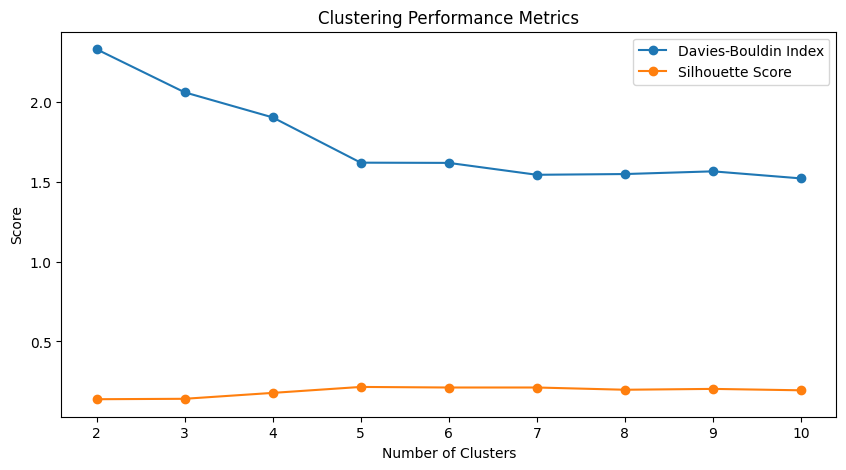

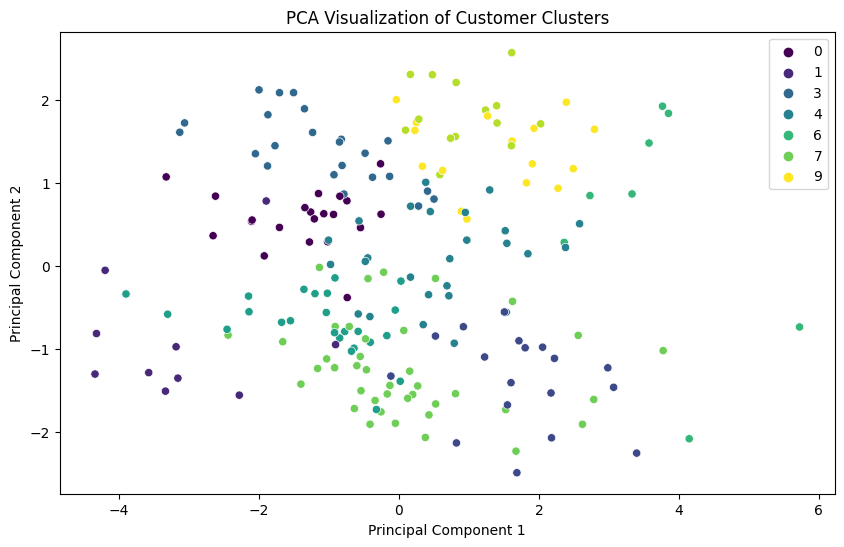

In [8]:
# Plot metrics
plt.figure(figsize=(10, 5))
plt.plot(k_values, db_scores, marker='o', label='Davies-Bouldin Index')
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Clustering Performance Metrics')
plt.legend()
plt.show()

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='viridis')
plt.title('PCA Visualization of Customer Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [9]:
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_scores[optimal_k - 2]:.4f}")
print(f"Silhouette Score: {silhouette_scores[optimal_k - 2]:.4f}")

# Cluster analysis
cluster_profile = features.copy()
cluster_profile['Cluster'] = labels
print("\nCluster Statistics:")
print(cluster_profile.groupby('Cluster').mean())

Optimal number of clusters: 10
Davies-Bouldin Index: 1.5212
Silhouette Score: 0.1936

Cluster Statistics:
             Tenure  Region_Asia  Region_Europe  Region_North America  \
Cluster                                                                 
0        710.333333          0.0          1.000                 0.000   
1        363.000000          0.3          0.200                 0.500   
2        510.888889          1.0          0.000                 0.000   
3        517.391304          0.0          0.000                 0.000   
4        413.961538          0.0          1.000                 0.000   
5        558.416667          1.0          0.000                 0.000   
6        658.000000          0.0          0.125                 0.125   
7        428.600000          0.0          0.000                 1.000   
8        625.357143          0.0          0.000                 0.000   
9        659.875000          0.0          0.000                 0.000   

         Region_S